## copying images to training, validation and test directories

In [2]:
import os, shutil, pathlib

#directory where the original dataset was uncompressed
original_dir = pathlib.Path("cats_vs_dogs/train/train")
#directory where we will store a smaller dataset
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir/subset_name/category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname, dst=dir/fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## instantiating a small convnet for dogs vs cats classifiaction

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) #the model expects RGB images o fsize 180 X 180
x = layers.Rescaling(1./255)(inputs) #rescale inputs to yhe [0, 1] range by dividing them by 255
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

## configuring the model for training

In [2]:
model.compile(loss="binary_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

## using image_dataset_from_directory to read images

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small\\train",
    image_size=(180,180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small\\validation",
    image_size=(180,180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small\\test",
    image_size=(180,180),
    batch_size=32)

#displaying the shapes of the data and labels yielded by the dataset
for data_batch, labels_batch in train_dataset:
    print("data batch shape:",data_batch.shape)
    print("labels batch",labels_batch.shape)
    break
    

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
data batch shape: (32, 180, 180, 3)
labels batch (32,)


## Fitting the model using a dataset

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 19s 123ms/step - loss: 0.7143 - accuracy: 0.5300 - val_loss: 1.2907 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 83ms/step - loss: 0.7105 - accuracy: 0.5490 - val_loss: 0.6800 - val_accuracy: 0.5640
Epoch 3/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6685 - accuracy: 0.6085 - val_loss: 0.6270 - val_accuracy: 0.6410
Epoch 4/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6415 - accuracy: 0.6445 - val_loss: 0.6201 - val_accuracy: 0.6510
Epoch 5/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6033 - accuracy: 0.6945 - val_loss: 0.6947 - val_accuracy: 0.6010
Epoch 6/30
63/63 [==============================] - 5s 80ms/step - loss: 0.5530 - accuracy: 0.7290 - val_loss: 0.6254 - val_accuracy: 0.6520
Epoch 7/30
63/63 [==============================] - 5s 80ms/step - loss: 0.5086 - accuracy: 0.7405 - val_loss: 0.9307 - val_accuracy: 0.6220
Epoch 8/30


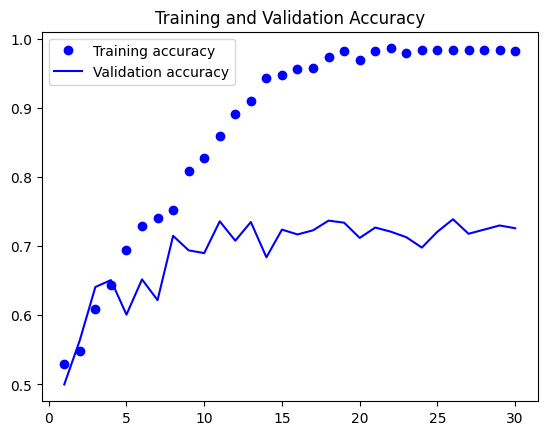

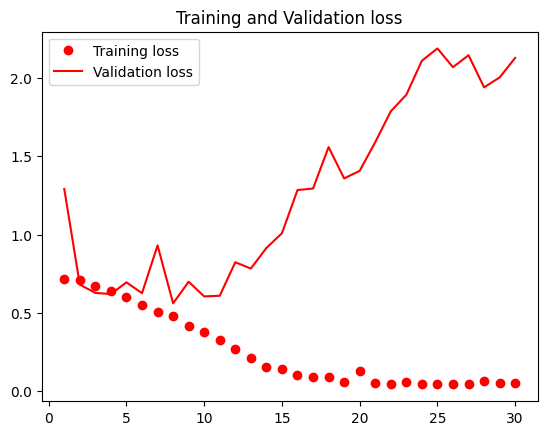

In [10]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()